# [E-9] 나의 첫 번째 캐글 경진대회

### 시도해볼 수 있는 방법

> * 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
> * LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
> * 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
> * Baseline 커널에서 활용했던 블렌딩 방법 활용하기


## 1. Kaggle project

https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

### Competition background

 이번에 분석하실 데이터는 20개의 변수를 가지고 있으며, 어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델을 만드는 것을 목표로 합니다.

### Evaluation

이번 대회의 평가 방식은 Root Mean Squared Error 입니다.

## 2. 데이터 불러오기

* train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
* test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
* sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)


### 필요한 라이브러리 설치 및 import

In [ ]:
$ conda install -c conda-forge xgboost
$ conda install -c conda-forge lightgbm
$ conda install -c conda-forge missingno

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('완료')

완료


### 데이터 경로 지정

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/home/aiffel-dj23/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj23/aiffel/kaggle_kakr_housing/data/test.csv


### 데이터 불러오기

In [4]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


* 테스트 데이터는 물론 우리가 맞추어야 할 집의 가격, price가 없기 때문에 컬럼이 하나 적다.

## 3. Data EDA 

>데이터를 깊게 탐색하는 EDA 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제하는 것이 매우 중요하다. 데이터가 무엇이냐에 따라, 그리고 그 데이터를 어떻게 정제하느냐에 따라 모델의 파라미터를 튜닝하는 것만으로는 절대 얻을 수 없는 성능 향상이 이루어질 수 있다. 

### 3-1. 데이터 전처리

In [7]:
train_len = len(train)
data = pd.concat((train, test), axis=0)     # 데이터 합치기

print(len(data))

21503


In [8]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,NaN,3,1.75,1500,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,NaN,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,NaN,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,NaN,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,NaN,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


#### 결측값 확인

In [10]:
data.isnull().sum()

id                  0
date                0
price            6468
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

* train과 test 데이터셋을 합쳤기 때문에 test 데이터셋의 price는 6468이 Nan이 정상이며, 이외 결측값은 없는 것이 확인되었다.

#### 중복값 확인

In [11]:
data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Length: 21503, dtype: bool

* 중복값은 없다.

In [ ]:
# for c in data.columns:                    # 결측치 개수 출력 확인하기
#    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

#### 'id' 삭제하기

In [12]:
test_id = data['id'][train_len:]
del data['id']                       # id 칼럼 삭제하기

print(data.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 'date' 정수형으로 처리하기

In [13]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)    # 연/월 데이터 사용, 정수형
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [14]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

In [15]:
print(len(data))

21503


In [16]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [17]:
data.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,201406,NaN,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,NaN,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,NaN,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,NaN,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,201501,NaN,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [18]:
data.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,1.503500e+04,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,201438.639539,5.406827e+05,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,44.281419,3.715247e+05,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,201405.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,201407.000000,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,201410.000000,4.500000e+05,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,201502.000000,6.450000e+05,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,201505.000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### 결과

> * bedrooms, bathrooms, floors 은 개수 (이산형 변수)
> * sapf_living, sapf_lot, sapf_above, sapf_basement, sqft_living15, sqft_lot15은 면적(연속형 변수)
> * waterfront(리버뷰 유무): 0, 1 (범주형 변수)
> * view: 0, 1, 2, 3, 4 (범주형 변수)
> * condition: 1, 2, 3, 4, 5 (범주형 변수)
> * grade: 1~13 등급
> * yr_built, yr_renovated : 년도 
> * zipcode : 우편번호 
> * lat, long : 위도, 경도

### 3-2. 변수 분포 확인 및 로그 변환

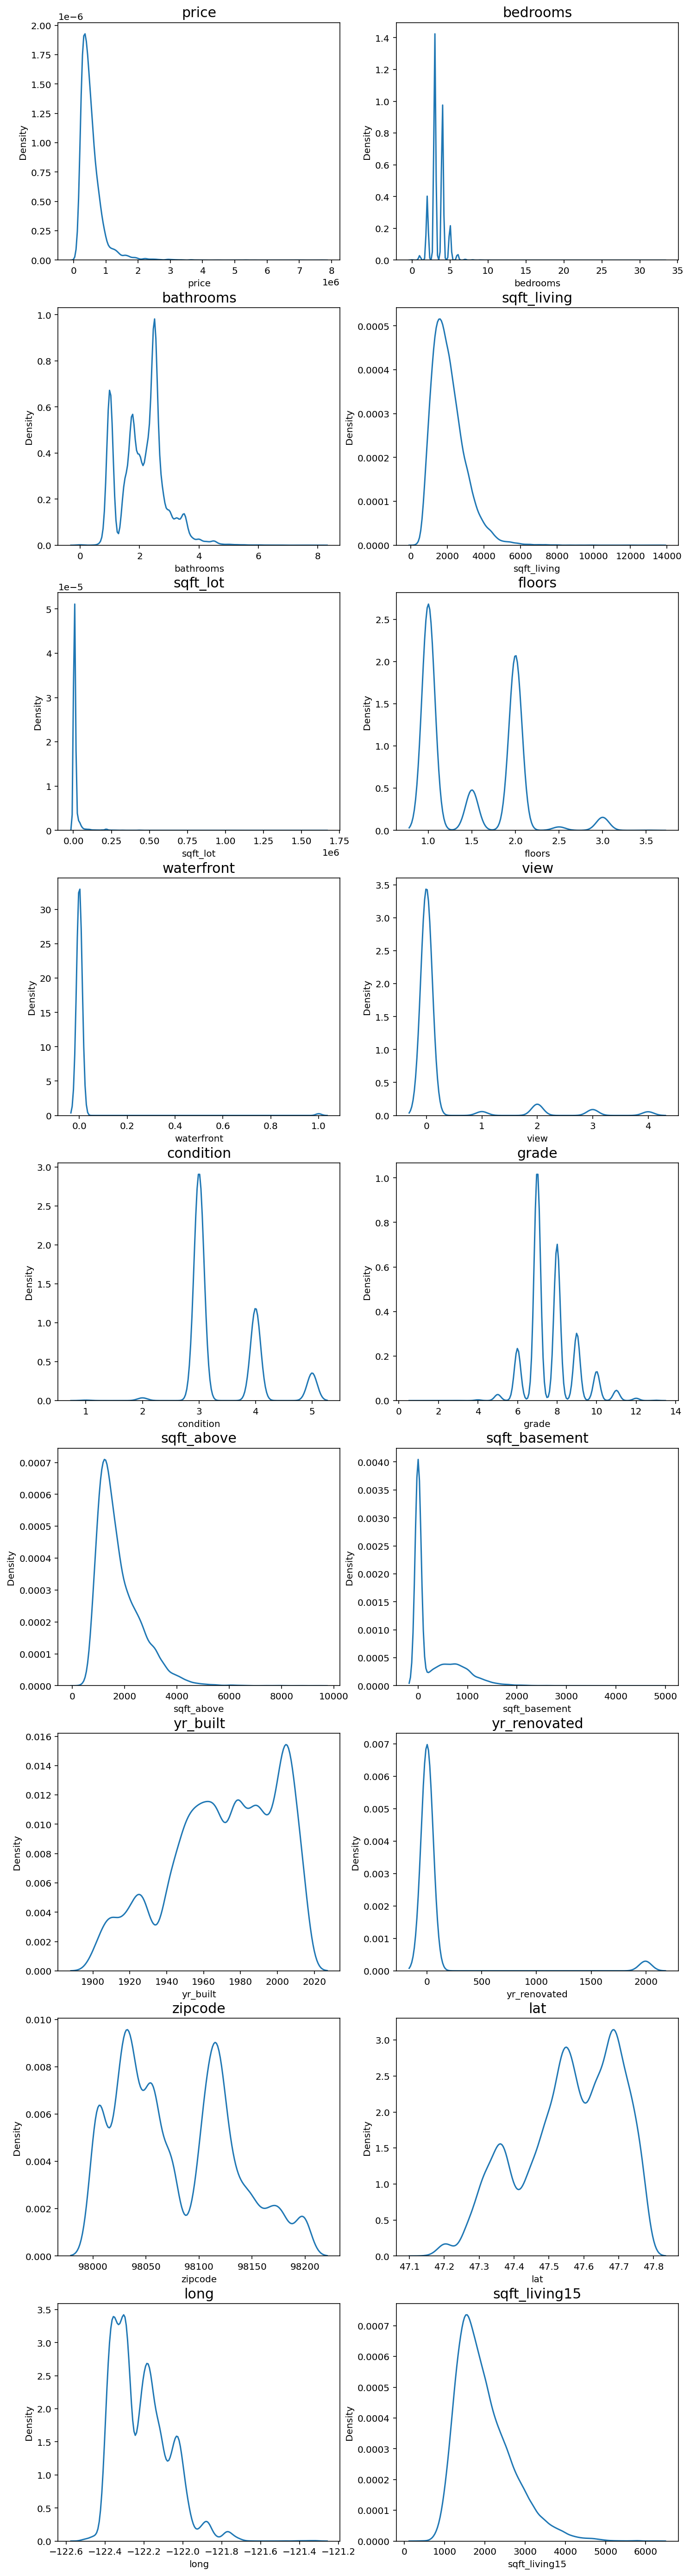

In [19]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로 스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns

for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

#### 로그 변환

위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보인다.
이렇게 한 쪽으로 치우친 분포의 경우에는 **로그 변환(log-scaling)을** 통해 데이터 분포를 정규분포에 가깝게 만들 수 있다. 

* 0<x<1 범위에서는 기울기가 매우 가파르다. 즉, x의 구간은 (0,1)로 매우 짧은 반면, y의 구간은 (−∞,0)으로 매우 크다.
* 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수값인 y값들은 매우 큰 범위로 벌어지게 된다. 즉, **로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가진다.**
* 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아진다. 이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, **따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가진다.** 

In [20]:
skew_columns = ['price','bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)           # 로그 변환

print('완료')

완료


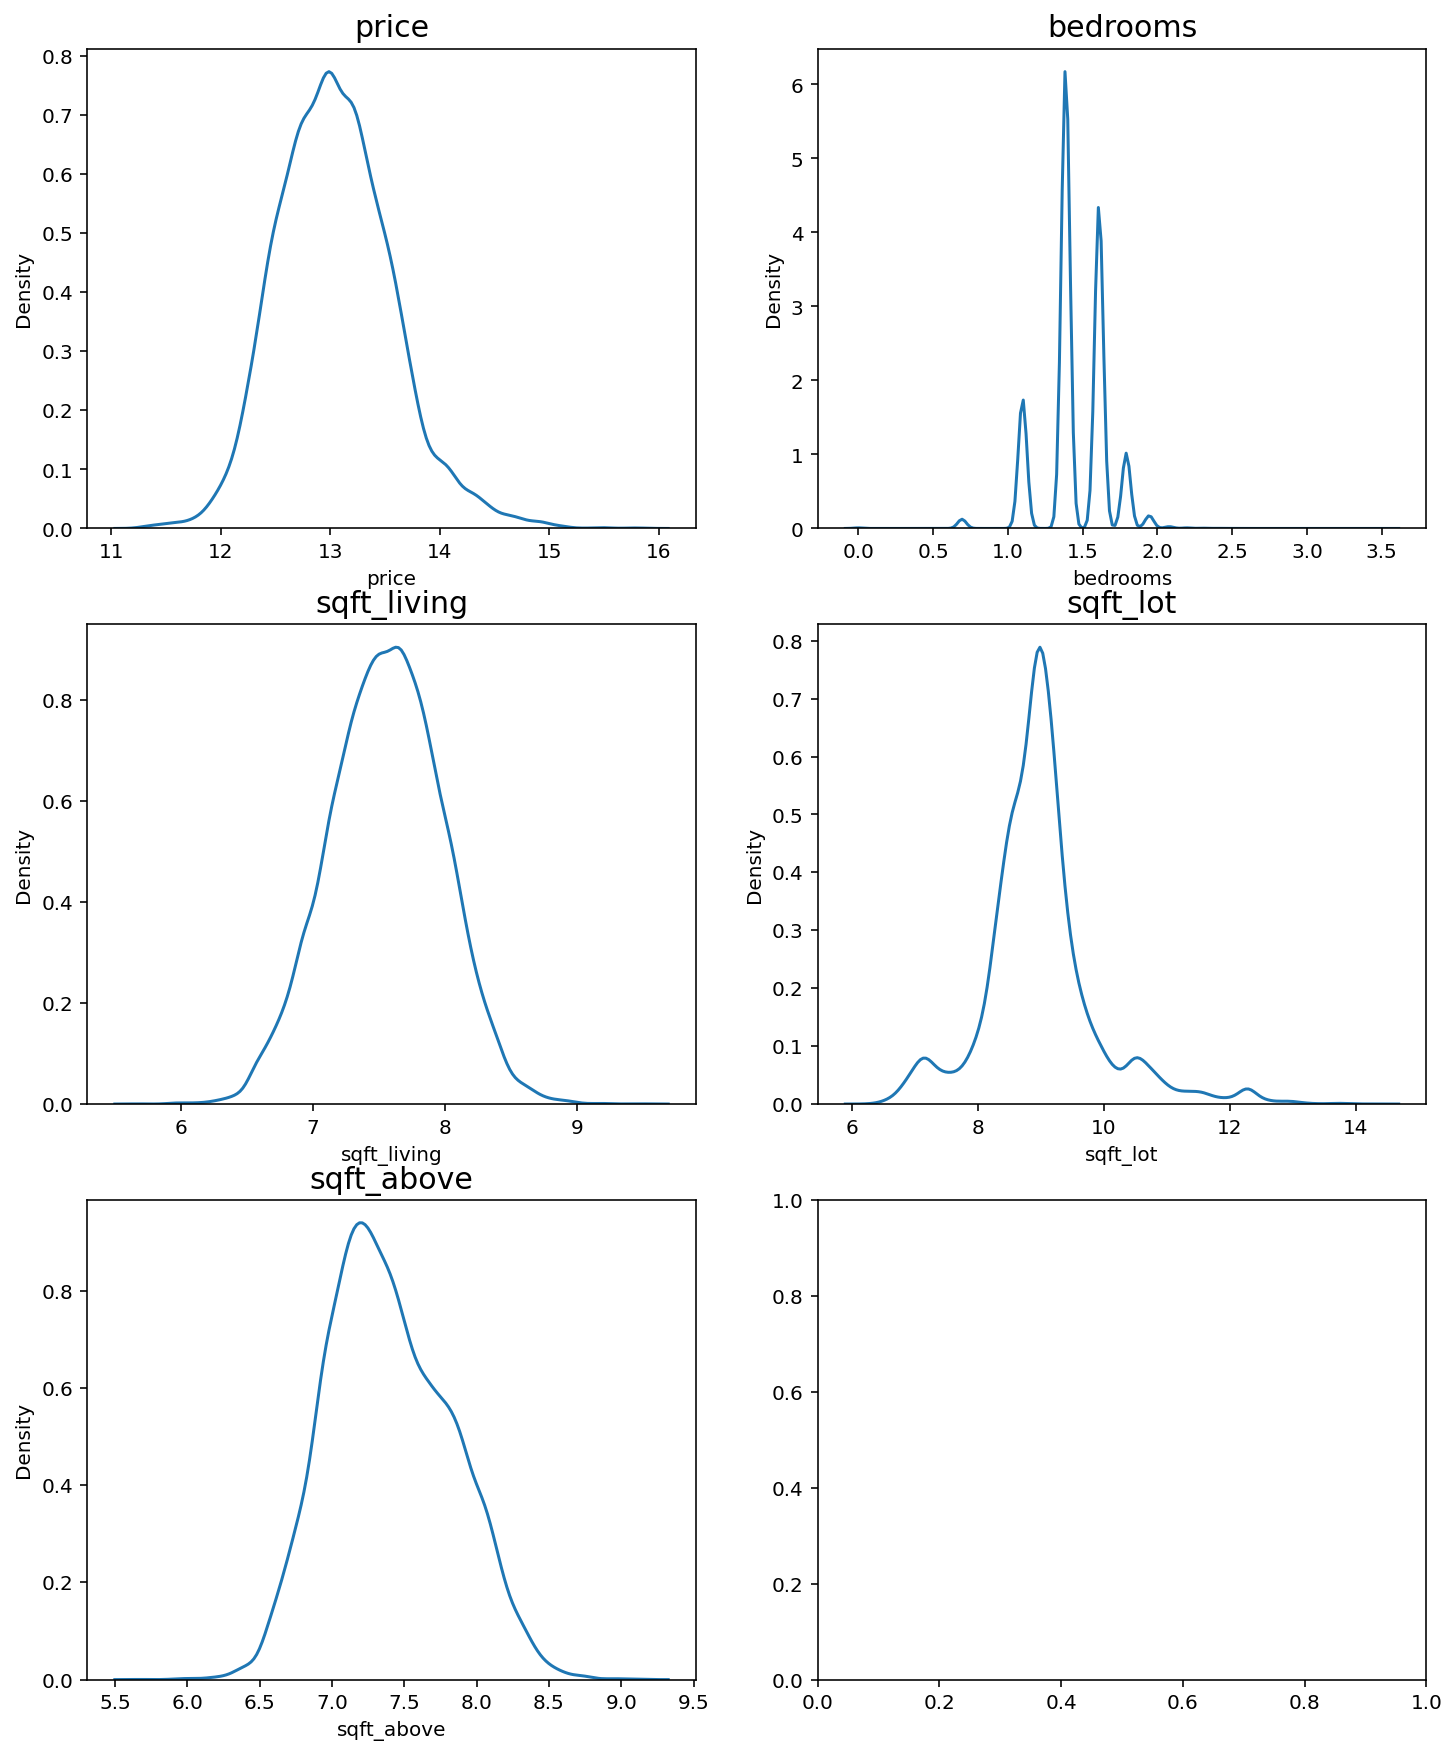

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### 3-3. 전체 데이터 다시 나누기

위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장하고, train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장한다.

In [22]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 20)
(6468, 20)


In [23]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309987,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,12.100718,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,13.142168,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,12.458779,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,12.583999,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711


In [24]:
test.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,NaN,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,NaN,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,NaN,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,NaN,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,NaN,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,2390,7570


### 3-4. 시각화 하기

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

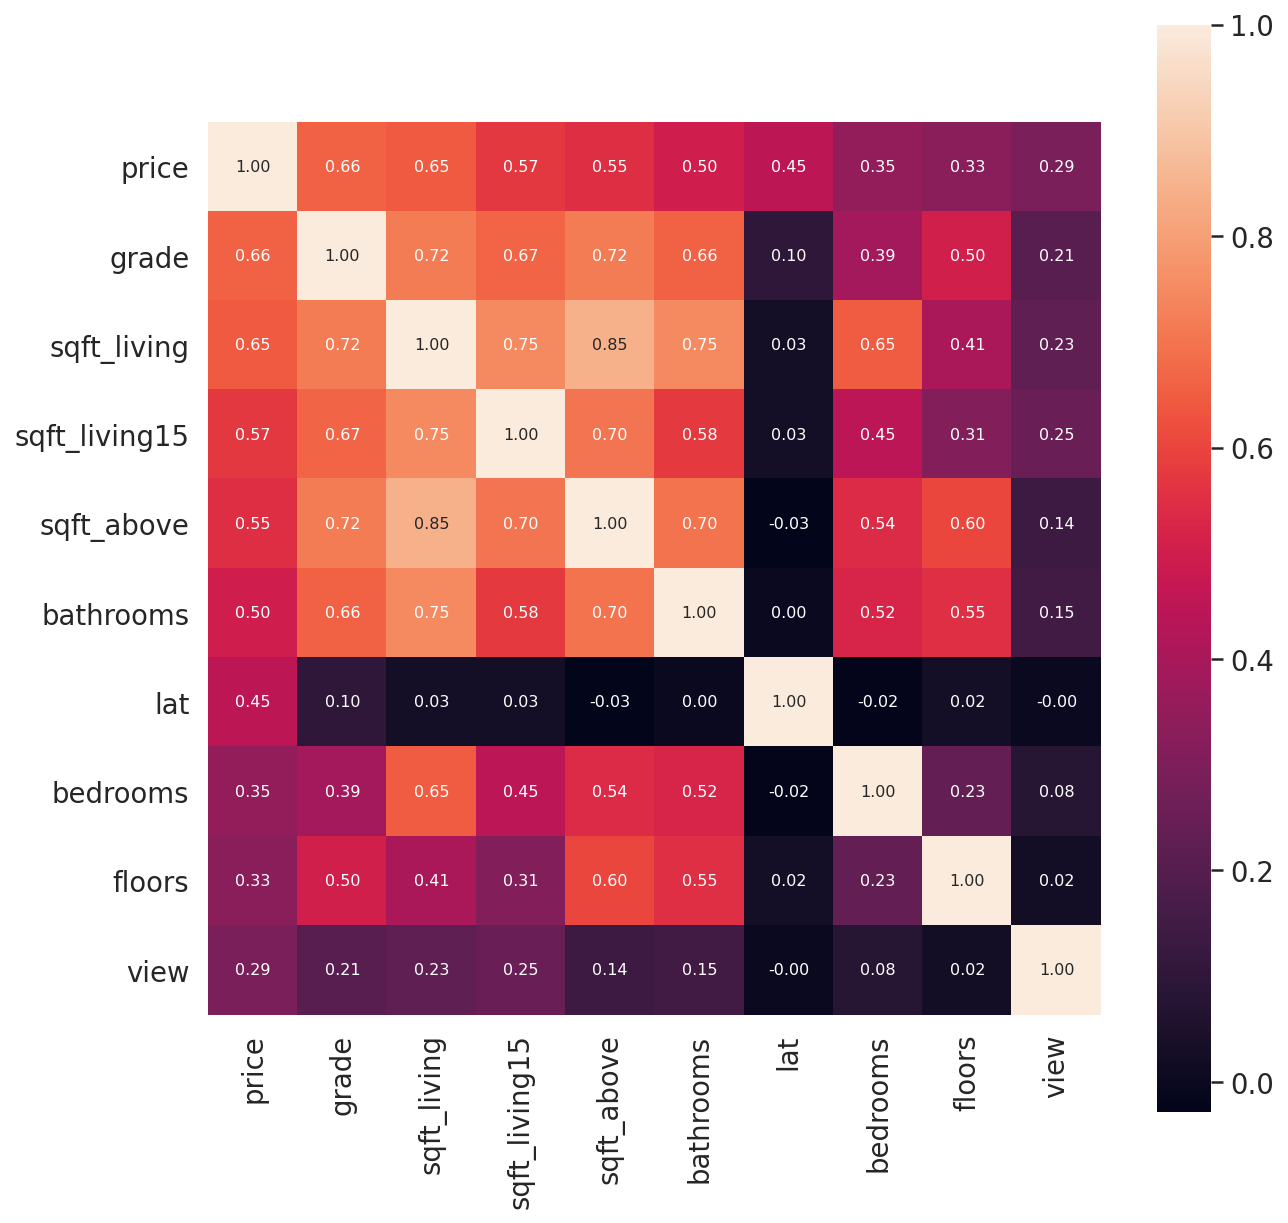

In [25]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price와 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10

print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

### 결과

>집가격과 상관도가 높은 변수집가격과 상관도가 높은 변수는 집의 등급, 주거공간의 면적, 2015년 기준 주거 공간 면적, 지하실을 제외한 면적, 화장실 수, 위도 순이다. 위도의 상관도가 높은 이유는 위의 지역은 시애틀인데 시애틀은 북쪽으로 갈 수록 살기 좋은 집들이 많다고 한다.
>
>* 위도와 집값 상관 관계
>https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83549

### 3-5. 학습 데이터 라벨 별도 저장

In [26]:
y = train['price']                 # 학습 데이터에서 라벨 별도로 저장
del train['price']                  # 삭제 
del test['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   float64
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   float64
 4   sqft_lot       6468 non-null   float64
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   float64
 11  sqft_basement  6468 non-null   float64
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

In [29]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

## 4. 모델 설계하기

### 4-1. 하이퍼 파라미터 조정하기

### RMSE 계산

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error    

print('완료')

완료


**주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다.**

In [31]:
def rmse(y_test, y_pred):                 # 함수 만들기
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))   # 로그 다시 변환

print('완료')

완료


### 모델 설계하기(4가지 모델의 RMSE)

 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor

In [32]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('완료')

완료


In [33]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('완료')

완료


* 모델 파라미터 초기화나 데이터셋 구성에 사용되는 랜덤 시드값인 random_state 값을 특정 값으로 고정시키거나, 아니면 지정하지 않고 None으로 세팅할 수 있다. 
* random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현된다. 
* 하지만 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라진다. 
* 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 한다. 따라서 위와 같이 random_state 값을 특정 값으로 고정시킨다.

In [34]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [35]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.17376623847,
 'XGBRegressor': 110319.30179305901,
 'LGBMRegressor': 111906.9477184206,
 'RandomForestRegressor': 125325.08375075871}

In [36]:
def get_scores(models, train, y):             # 함수 만들기
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)      # 로그 원래대로 변환
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [37]:
 get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.173766
RandomForestRegressor,125325.083751
LGBMRegressor,111906.947718
XGBRegressor,110319.301793


### 결과

> XGBRegressor가 RMSE 값이 110319.301793으로 성능이 가장 좋았다. 그 다음으로 LGBMRegressor, RandomForestRegressor, GradientBoostingRegressor 이다.

### 4-2. 튜닝 시도하기

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같다.

> * max_depth : 의사 결정 나무의 깊이, 정수 사용
>* learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
>* n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
>* num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
>* boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

my_GridSearch(), save_submission() 등의 함수를 사용해도 되고, 혹은 여러분이 원하는 새로운 함수를 만들어서 사용해도 된다.

#### 그리드 탐색

In [38]:
from sklearn.model_selection import GridSearchCV

print('완료')

완료


GridSearchCV를 이용해서 grid_model 모델을 초기화하고, train과 y 데이터로 모델을 간단히 학습시키면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료된다.

>* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
>* scoring : 모델의 성능을 평가할 지표
>* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
>* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
>* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수


다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현한다.

>1. GridSearchCV 모델로 `model`을 초기화합니다.
>2. 모델을 fitting 합니다.
>3. params, score에 각 조합에 대한 결과를 저장합니다. 
>4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.


#### my_GridSearch() 함수 만들기

In [42]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

**Check point)**  왜 neg_mean_squared_error를 사용하는가?

> 답 설명

In [43]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('완료')

완료


#### 1) LGBMRegressor

param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비한다.

In [44]:
param_grid = {
    'n_estimators': [50, 100],                    # 하이퍼 파라미터
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.6s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


가장 좋은 조합은 max_depth=10, n_estimators=100, RMSLE 0.16438 이다.

#### 2) RandomForestRegressor

In [45]:
param_grid = {
    'n_estimators': [50, 100, 120],
    'max_depth': [1, 10, 12],
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   17.4s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:   30.2s finished


,max_depth,n_estimators,score,RMSLE
8,12,120,-0.033082,0.181884
7,12,100,-0.033158,0.182093
6,12,50,-0.033395,0.182744
5,10,120,-0.035139,0.187453
4,10,100,-0.035227,0.187688
3,10,50,-0.035430,0.188228
2,1,120,-0.179084,0.423183
1,1,100,-0.179128,0.423235
0,1,50,-0.179746,0.423965


가장 좋은 조합은 max_depth=12, n_estimators=120, RMSLE 0.181884이다.

#### 3) GradientBoostingRegressor

In [46]:
param_grid = {
    'n_estimators': [50, 100, 120],
    'max_depth': [1, 10, 12],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   25.8s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:   45.5s finished


,max_depth,n_estimators,score,RMSLE
5,10,120,-0.029422,0.171527
4,10,100,-0.029480,0.171696
3,10,50,-0.029888,0.172881
8,12,120,-0.032655,0.180706
7,12,100,-0.032668,0.180743
6,12,50,-0.032897,0.181374
2,1,120,-0.051744,0.227473
1,1,100,-0.055039,0.234603
0,1,50,-0.073256,0.270658


가장 좋은 조합은 max_depth=10, n_estimators=120, RMSLE 0.171527이다.

#### 4) XGBRegressor

In [47]:
param_grid = {
    'n_estimators': [50, 100, 120],
    'max_depth': [1, 10, 12],
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   34.1s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  1.0min finished


,max_depth,n_estimators,score,RMSLE
3,10,50,-0.030352,0.174218
4,10,100,-0.030476,0.174574
5,10,120,-0.030507,0.174663
6,12,50,-0.031122,0.176414
7,12,100,-0.031225,0.176707
8,12,120,-0.031239,0.176745
2,1,120,-0.041674,0.204142
1,1,100,-0.043046,0.207475
0,1,50,-0.048745,0.220782


가장 좋은 조합은 max_depth=10, n_estimators=50, RMSLE 0.174218이다.

### 저장하기-01

아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현한다.
>1. 모델을 `train`, `y`로 학습시킵니다.
>2. `test`에 대해 예측합니다.
>3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.

In [48]:
def save_submission(model, train, y, test, model_name, rmsle=None):  # 함수 만들기
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)                      # 원래 스케일로 되돌리기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)              # csv 저장하기
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [49]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.01643')

/home/aiffel-dj23/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.01643.csv saved!


### 제출-01

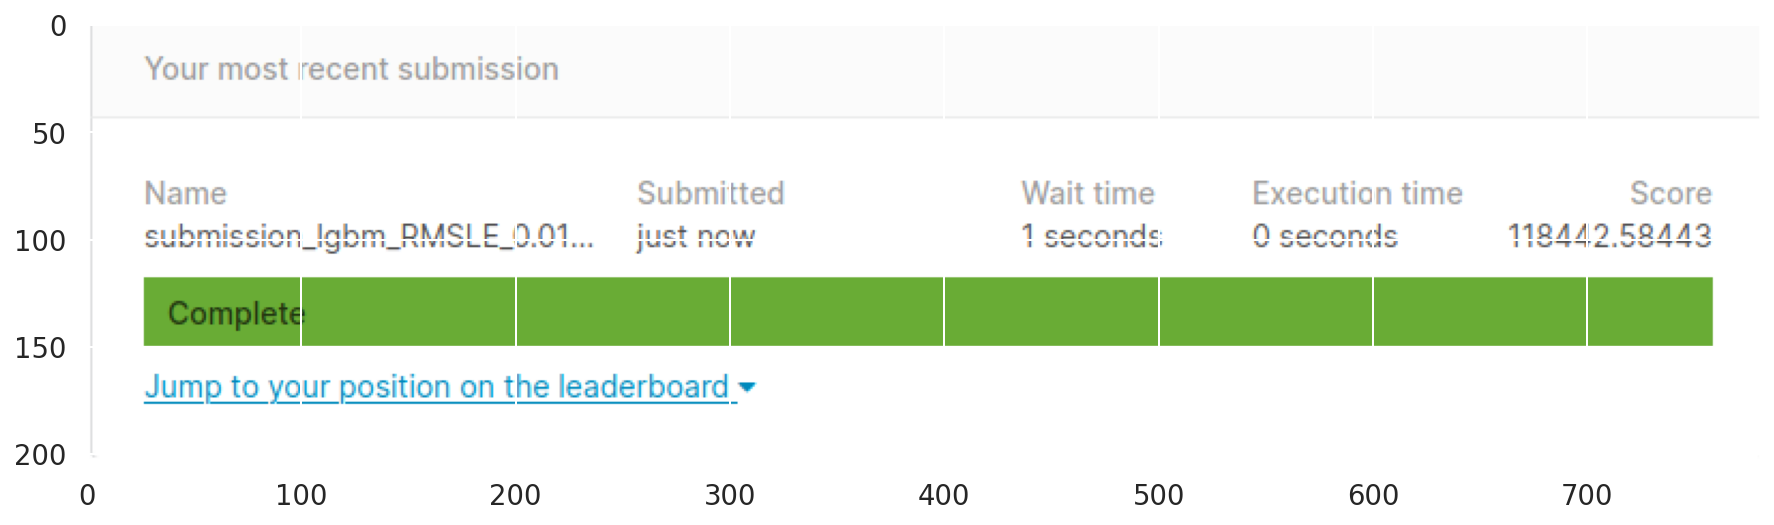

In [50]:
import os
import cv2
from matplotlib import pyplot as plt

img_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/result01.png'   
img = cv2.imread(img_path)
result01= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     
plt.figure(figsize = (15, 20))
plt.imshow(result01)      
plt.show()

### 결과-01
lightgbm의 하이퍼 파라미터를 조정한 모델의 Score는 118442.58443이다.

### 4-3. 블렌딩하기

> * Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용한다.
> * 블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법이다.

#### 교차 검증(Cross Validation)

In [51]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                                  kf=kfold))
print('완료')

완료


In [52]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('완료')

완료


In [53]:
get_cv_score(models)          # 결정계수

Model XGBoost CV score : 0.8973
Model LightGBM CV score : 0.9025


* cross_val_score() 함수는 회귀모델을 전달할 경우 R2 점수를 반환한다.
결정계수 R2 값은 1에 가까울수록 모델이 잘 학습되었다는 것을 나타낸다.

In [64]:
def AveragingBlending(models, train, y, test):       # 블렌딩 기법
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)     # 평균값 반환

print('완료')

완료


* Baseline 모델에서는 다음과 같이 **여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AgeragingBlending() 함수를 만들어 사용**한다. AgeragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤, **predictions에 그 예측 결괏값을 모아서 평균한 값을 반환한다.**

In [65]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

6468


array([13.11480437, 13.06002629, 14.08119752, ..., 13.04942107,
       12.69892454, 13.01982138])

### 저장하기-02

In [56]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,13.114804
1,15036,13.060026
2,15037,14.081198
3,15038,12.619925
4,15039,12.708484


In [78]:
submission.tail()

,id,price
6463,21498,12.455919
6464,21499,12.899808
6465,21500,13.049421
6466,21501,12.698925
6467,21502,13.019821


In [57]:
result = pd.DataFrame({                      # 데이터프레임 만들기
    'id' : test_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,13.114804
1,15036,13.060026
2,15037,14.081198
3,15038,12.619925
4,15039,12.708484


In [58]:
submission_path = join(data_dir, 'sample_submission.csv')      # 저장하기
result.to_csv(submission_path, index=False)

print(submission_path)

/home/aiffel-dj23/aiffel/kaggle_kakr_housing/data/sample_submission.csv


### 제출-02

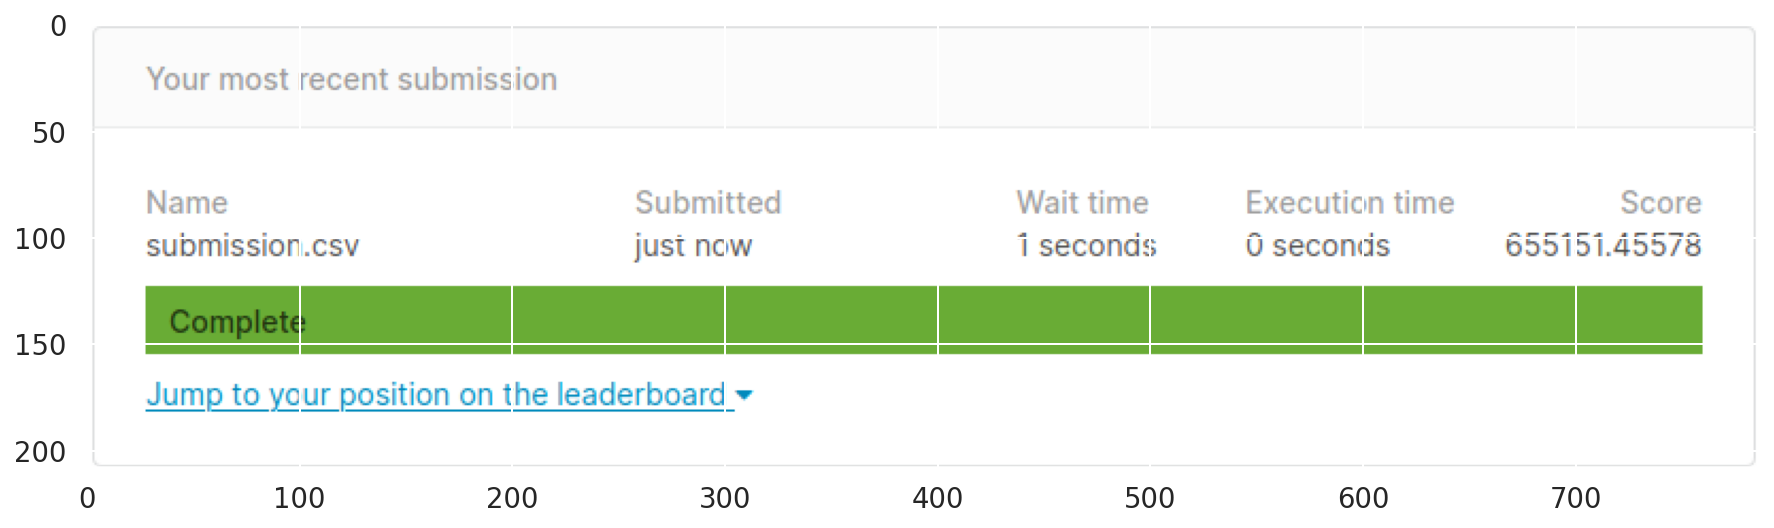

In [59]:
import os
import cv2
from matplotlib import pyplot as plt

img_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/result02.png'   
img = cv2.imread(img_path)
result02= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     
plt.figure(figsize = (15, 20))
plt.imshow(result02)      
plt.show()

### 결과-02 
xgboost, lightgbm을 블렌딩한 모델의 Score는 655151.45578으로 하이퍼 파라미터를 조정한 lightgbm 모델보다 스코어가 많이 낮았다. 

### 4-4. 스태킹 앙상블

기 작성된 코드들을 변환하여 스태킹 앙상블을 시도해 보았다.

세부 구성 모델: XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor

In [66]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [67]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = y
X_features = train

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.252
Ridge 로그 변환된 RMSE: 0.252
Lasso 로그 변환된 RMSE: 0.399


[0.25240494546862147, 0.2524082026544208, 0.3994354983319933]

In [68]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)

In [69]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

In [86]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [71]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [74]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델 적용. 
meta_model_lgbm = lgbm_reg

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lgbm.fit(Stack_final_X_train, y_train)
final = meta_model_lgbm.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.16370493792910387


## 결과

> lightgbm 회귀 모델의 하이퍼 파라미터가장 좋은 조합은 max_depth=10, n_estimators=100, RMSLE 0.16438 이며, 캐글 Score는 118442.58443 이다. xgboost, lightgbm을 블렌딩한 회귀 모델은 캐글 Score가 655151.45578으로 하이퍼 파라미터를 조정한 lightgbm 모델보다 스코어가 많이 높았다(순위가 낮았다). 마지막으로 시도해본 스태킹 회귀 모델의 RMSE는 0.163704로 하이퍼 파라미터를 조정한 lightgbm 회귀 모델 보다 미세하게 성능이 좋았다.
>
> 일반적으로 여러가지 회귀 모델을 조합한 블렌딩 및 스태킹 회귀 모델의 결과가 좋다 하여 기대했는데, 실제로 해보니 생각만큼 좋지 않았다. 아무래도 블렌딩이나 스태킹은 여러가지 회귀 모델의 결과값을 평균내거나 재학습하는 구조이기 때문인 것 같다. 세부 구성이 되는 회귀 모델 중 성능이 많이 떨어지는 것이 있다면, 최종 결과에 큰 영향을 줄 것이다.  따라서 블렌딩, 스태킹 회귀 모델을 통해 좋은 결과를 얻기 위해서는 세부 구성 회귀 모델의 성능 확인과 선택적 조합이 중요하다.

## 총평

> 이번 노드는 회귀 모델을 통해 집의 가격을 예측하였다. 실제 캐글 데이터로 데이터 전처리에서부터 모델 선정과 학습-예측을 실습해 보고, 캐글에 결과를 업로드하여 상대적 성능을 평가할 수 있어서 좋은 기회였다. 추가적으로 성능이 좋은 회귀 모델의 회귀식은 어떻게 확인할 수 있는지, 찾아보면 좋을 것 같다.